In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier #,Ridge,Lasso,ElasticNet
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,KFold,RandomizedSearchCV,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder,StandardScaler,RobustScaler
from imblearn.over_sampling import ADASYN,KMeansSMOTE,SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import numpy as np
import pyreadstat
from collections import Counter

In [2]:
df = pd.read_csv("C:\\Users\\kiran\\Downloads\\loan_fraud.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [14]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

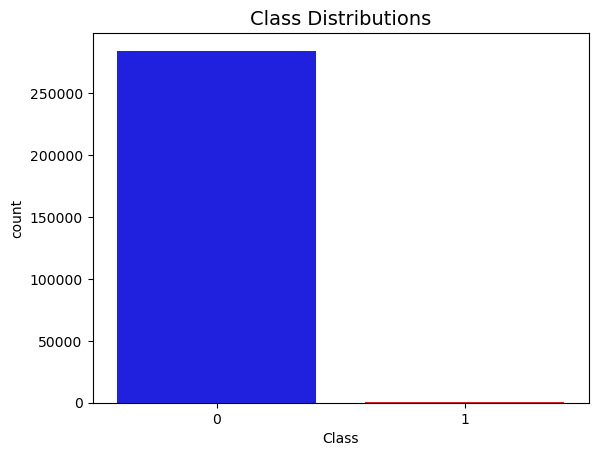

In [6]:
colors = ["Blue", "red"]

# Assuming 'df' is your DataFrame and 'Class' is the column name for class labels
sns.countplot(x='Class', data=df, palette=colors)  # Use 'x=' to specify the column name
plt.title('Class Distributions', fontsize=14)
plt.show()

In [17]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
152681,97437.0,1.929228,-0.417259,0.163512,0.347943,-0.652129,0.279548,-1.063071,0.126813,2.250107,...,-0.053518,0.206867,0.342307,0.755547,-0.607872,0.383069,-0.042608,-0.043696,15.95,0
201098,133731.0,1.176633,3.141918,-6.140445,5.521821,1.768515,-1.727186,-0.932429,0.292797,-3.156827,...,0.129372,-0.803021,-0.074098,-0.031084,0.375366,0.065897,0.488258,0.325872,0.00,1
126626,78041.0,-4.963486,-5.779236,-1.172616,0.188305,-7.338525,3.912507,7.865649,-0.042246,-0.824288,...,1.261483,-0.499309,5.301556,-0.186512,1.102405,1.058875,-0.982790,0.146479,2355.36,0
152223,97121.0,-17.976266,12.864989,-19.575066,11.345120,-13.998646,-0.354900,-23.783470,-4.872353,-8.504285,...,-4.300432,2.865772,1.489302,0.386039,-0.232392,0.413827,-3.255981,-0.538963,8.64,1
149587,91524.0,1.954852,1.630056,-4.337200,2.378367,2.113348,-1.583851,0.653745,-0.192892,1.217608,...,-0.474437,-0.974625,-0.048155,-0.023524,0.362192,-0.570709,0.025619,0.081880,1.00,1


Distribution of the Classes in the subsample dataset
Class
0    492
1    492
Name: count, dtype: int64


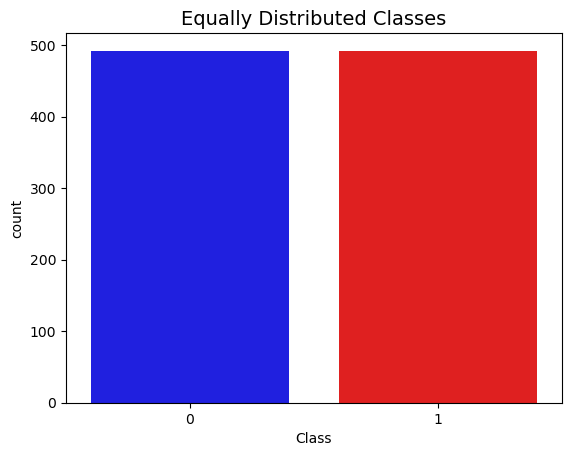

In [18]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts())



sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [19]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [24]:
logr_regression = LogisticRegression()
logr_regression.fit(X_train,y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr_regression.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,logr_regression.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,logr_regression.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,logr_regression.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr_regression.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr_regression.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,logr_regression.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,logr_regression.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,logr_regression.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr_regression.predict(X_test))))


C:\Users\kiran\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of training is 0.9440914866581956
Precision of training is 0.9592391304347826
Recall of training is 0.9240837696335078
F1 of training is 0.9413333333333334
ROC AUC of training is 0.9435233662982354

Accuracy of test is 0.8934010152284264
Precision of test is 0.9238095238095239
Recall of test is 0.8818181818181818
F1 of test is 0.9023255813953488
ROC AUC of test is 0.894932079414838


In [26]:
import pickle
import os

# Model to be pickled (example)
model = logr_regression # Replace this with your actual model

# Specify folder and file name
folder_path = 'C:\\Users\\kiran\\OneDrive\\Desktop\\StepWeek5\\AISCB_FraudDetection\\notebooks\\Processing\\'
file_name = 'best_logistic.sav'

# Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Full path for the .pkl file
full_path = os.path.join(folder_path, file_name)

# Pickle the model
with open(full_path, 'wb') as file:
    pickle.dump(model, file)